# Read Sort and Organize Data

In [ ]:
!pip install simpy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [29]:
import simpy as sm
import pandas as pd
import numpy as np
import math
import statistics
import random
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
import scipy.stats as stats

In [30]:
df_times=pd.read_csv('Picking Times - picking times looker data.csv')

In [31]:
df_times.columns=('CS #','Create Time','Assign Time','Pick Start','Pick End','Weight','Shipped')

In [32]:
df_times['Pick Start']=pd.to_datetime(df_times['Pick Start'])
df_times['Pick End']=pd.to_datetime(df_times['Pick End'])
df_times['Create Time']=pd.to_datetime(df_times['Create Time'])
df_times.drop(df_times[df_times['Pick End']=='NaT'].index, inplace=True)
df_times.drop(df_times[df_times['Pick Start']=='NaT'].index, inplace=True)

# Calculation of Duration Times for Picking


In [33]:
df_times['Duration']=df_times['Pick End']-df_times['Pick Start']

In [34]:
df_times['Duration']
df_times['Duration']=df_times['Duration'].astype('timedelta64[m]')

In [35]:
df_times['Minutes']=df_times['Duration'].values.astype("float64")
df_times['Minutes']

0       6.0
1       0.0
2      24.0
3      40.0
4      25.0
       ... 
495     6.0
496    22.0
497    11.0
498     0.0
499     0.0
Name: Minutes, Length: 500, dtype: float64

In [36]:
df_times.drop(df_times[df_times.Minutes > 100].index, inplace=True)
df_times.drop(df_times[df_times.Minutes < 5].index, inplace=True)
df_times.dropna(inplace=True)

(array([48., 26., 38., 22., 13., 14.,  4.,  8., 10.,  5.,  8.,  6.,  1.,
         3.,  2.]),
 array([ 5.        , 11.06666667, 17.13333333, 23.2       , 29.26666667,
        35.33333333, 41.4       , 47.46666667, 53.53333333, 59.6       ,
        65.66666667, 71.73333333, 77.8       , 83.86666667, 89.93333333,
        96.        ]),
 <a list of 15 Patch objects>)

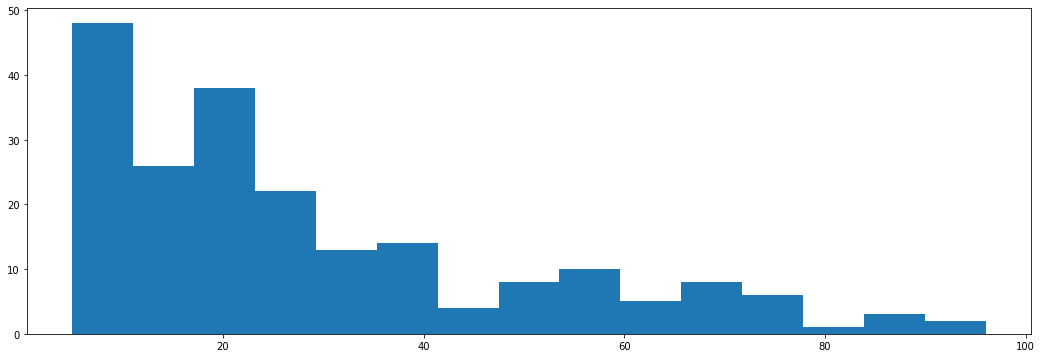

In [37]:
plt.figure(figsize=(18,6))
df_times['Minutes']
plt.hist(df_times['Minutes'],bins=15)

In [ ]:
df_times['Minutes']

1        8.0
2       27.0
3       25.0
5       62.0
6       27.0
        ... 
7257    30.0
7258    30.0
7259    37.0
7260    37.0
7261    10.0
Name: Minutes, Length: 6077, dtype: float64

In [ ]:
selim = stats.distributions.gamma.fit(df_times['Minutes'],floc=0)
gamma_alpha=selim[0]
gamma_beta=selim[2]
gamma_beta

14.284594263624331

In [ ]:
gamma_alpha

2.031841991861685

# Order Arrival Estimation 



In [38]:
Start=df_times.sort_values('Create Time')['Create Time']
Start.index=range(len(df_times['Create Time']))

In [39]:
value1=Start.iloc[lambda x: x.index % 2 == 0]
value2=Start.iloc[lambda x: x.index % 2 == 1]

In [40]:
value1.index=range(len(value1))

In [41]:
value2.index=range(len(value2))


In [42]:
difference=value2-value1

In [43]:
difference

0     0 days 00:07:46
1     0 days 00:01:27
2     0 days 00:10:22
3     0 days 00:06:36
4     0 days 00:02:36
            ...      
99    0 days 00:01:29
100   0 days 00:07:28
101   0 days 00:05:57
102   0 days 00:00:14
103   0 days 00:25:26
Name: Create Time, Length: 104, dtype: timedelta64[ns]

In [44]:
difference.dropna(inplace=True)
difference=difference.astype('timedelta64[m]')

In [45]:
difference=difference.astype("float64")

In [ ]:
from pandas.core.frame import DataFrame
df_6=DataFrame(difference)

In [46]:
df_6.columns=(['Differ'])

In [47]:
df_6

,Differ
0,7.0
1,1.0
2,10.0
3,6.0
4,2.0
...,...
99,1.0
100,7.0
101,5.0
102,0.0


In [48]:
df_6.drop(df_6[df_6.Differ > 50].index, inplace=True)

(array([39., 27., 16.,  5.,  3.,  4.,  0.,  3.,  2.,  1.]),
 array([ 0. ,  4.7,  9.4, 14.1, 18.8, 23.5, 28.2, 32.9, 37.6, 42.3, 47. ]),
 <a list of 10 Patch objects>)

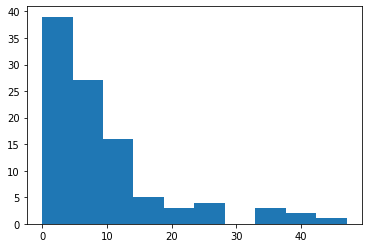

In [54]:
plt.hist(df_6['Differ'])

In [50]:
selim2= stats.distributions.expon.fit(df_6['Differ'],floc=0)

In [55]:
expo_mean=selim2[1]
expo_mean

9.07

In [64]:
wait_times = []##get these as inputs from the user
num_order=[]

# Simulation 

In [56]:
class Warehouse (object):
  def __init__(self,env,num_picker):
    self.env = env
    self.picker = sm.Resource(env, num_picker) ##resource defines how many pickers can be included in the envirenment.
  def picking_times(self,order): ##the order initiates the picking process, it is passed on as an argument.
    yield self.env.timeout(random.gammavariate(gamma_alpha,gamma_beta))

In [57]:
def start_picking(env,order,warehouse):
  picking_start = env.now 
  with warehouse.picker.request() as request:
    yield request ## request is used to calculate the wait time of orders for pickers
    wait_times.append(env.now-picking_start)
    yield env.process(warehouse.picking_times(order)) ##picker is a shared source, many orders will try to use the same pickers.

    #wait_times.append(env.now-picking_start)

In [58]:
def quality_assurance(env,order,warehouse):
  qa_start = env.now
  with warehouse.qa.request() as request:
    yield request
    yield env.e

In [59]:
def run_warehouse(env,num_picker):
  warehouse = Warehouse(env,num_picker)
  
  for order in range(10):
    env.process(start_picking(env,order,warehouse))
    

  while True:
    yield env.timeout(random.expovariate(1/expo_mean))
    order +=1
    env.process(start_picking(env,order,warehouse))
    num_order.append(order)



In [60]:
def get_average_time(wait_times):
  average_wait=statistics.mean(wait_times)
  return average_wait

In [61]:
def get_user_input2():
  num_picker=input("Input # of pickers: ")
  params = num_picker
  if str(params).isdigit() : #check if input is digit or not
    params=int(params) 
  else:
    print("Could not parse input. The simulation will use default values:",
            "\n1 picker")
    params = 1
  return params
def get_user_input():
  total1=input("Input # of hours of simulation: ")
  params = total1
  if str(params).isdigit() : #check if input is digit or not
    params=int(params) 
  else:
    print("Could not parse input. The simulation will use default values:",
            "\n16 hours")
    params = 16
  return params  

In [62]:
def main():
  #random.seed(54) ## to keep using the same randomness
  num_picker=get_user_input2()
  total_hours=get_user_input()
  env = sm.Environment()
  env.process(run_warehouse(env,num_picker/2))
  env.run(until=total_hours*60)
  time=get_average_time(wait_times)
  total_time=sum(wait_times)
  total_order=num_order[len(num_order)-1]
  print("The idle time(minutes) of orders on average are:",time)
  print("The idle time(minutes) of orders in total are:",total_time)
  print("Total number of orders for the timeline is", total_order)
  

# Execution of Simulation

In [65]:
if __name__ == '__main__':
    main()

Input # of pickers: 16
Input # of hours of simulation: 12
The idle time(minutes) of orders on average are: 4.660823391379289
The idle time(minutes) of orders in total are: 386.8483414844809
Total number of orders for the timeline is 82
